In [1]:
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .otherwise(-1))  

feature_columns = [
    # Field Position & Time
    'yardline_100', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 
    'score_differential_post', 'posteam_score_post',

    # Game Context & Situational Awareness
    'quarter_seconds_remaining', 'half_seconds_remaining', 'drive', 'score_differential',

    # Play History (Momentum)
    'play_success', 'cumulative_rush_attempts', 'cumulative_pass_attempts', 
    'cumulative_rush_successes', 'cumulative_pass_successes', 'rush_success_rate', 
    'pass_success_rate', 'posteam_leading', 'posteam_trailing',

    # Critical 3rd/4th Down Context
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed',

    # Play Consequences
    'incomplete_pass', 'sack', 'touchback', 'interception',

    # Special Teams Indicators
    'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 'punt_out_of_bounds'
]


assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

games = df_vector.select("game_id").distinct().collect()  
train_games = games[:int(0.8 * len(games))] 
test_games = games[int(0.8 * len(games)):]

train_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in train_games]))
test_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in test_games]))

# === 1. CONVERT DATA TO PANDAS === #
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Convert feature vectors back to NumPy arrays
X_train = np.array(train_pandas["features"].tolist())
y_train = np.array(train_pandas["play_type_index"].tolist())

X_test = np.array(test_pandas["features"].tolist())
y_test = np.array(test_pandas["play_type_index"].tolist())

# === 2. TRAIN XGBOOST MODEL === #
xgb = XGBClassifier(
    max_depth=9,  
    learning_rate=0.05,  
    n_estimators=200,  
    scale_pos_weight=1,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42
)

xgb.fit(X_train, y_train)

# === 3. MAKE PREDICTIONS === #
y_pred = xgb.predict(X_test)

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [3]:
test_pandas["predicted_play"] = y_pred
test_pandas["actual_play"] = y_test

# Define class labels
class_labels = ["Pass", "Run", "Punt", "Field Goal"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Compute Overall Metrics
accuracy = (y_test == y_pred).mean()
precision = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"]
recall = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"]
f1 = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]

# Show Metrics
print(f"**Accuracy:** {accuracy:.4f}")
print(f"**Precision:** {precision:.4f}")
print(f"**Recall:** {recall:.4f}")
print(f"**F1 Score:** {f1:.4f}")


**Accuracy:** 0.8535
**Precision:** 0.8544
**Recall:** 0.8535
**F1 Score:** 0.8539


<Figure size 1200x600 with 0 Axes>

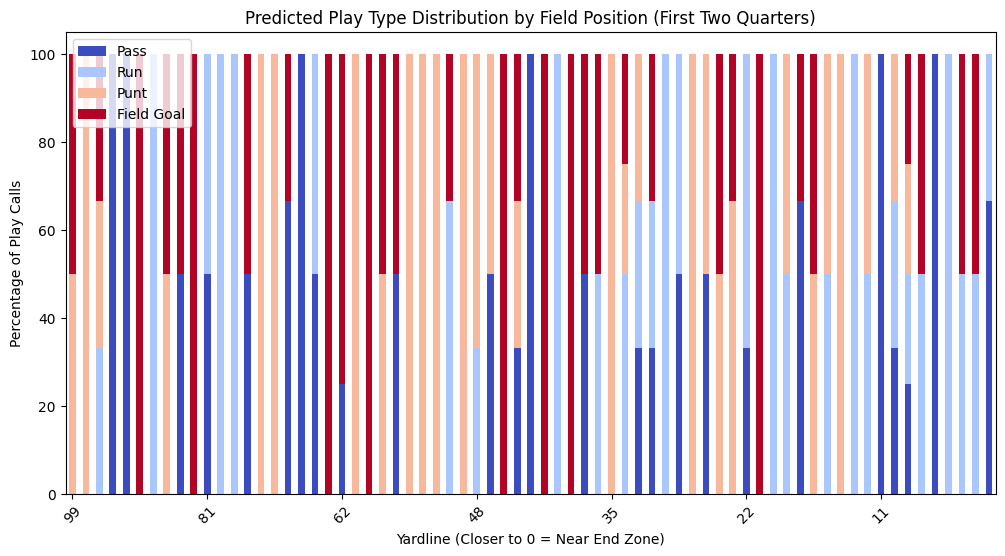

In [8]:
%matplotlib inline

# Simulating test_pandas DataFrame with realistic football conditions
np.random.seed(42)
num_samples = 500

# Generate example teams
teams = ["TeamA", "TeamB", "TeamC", "TeamD"]

test_pandas = pd.DataFrame({
    "yardline_100": np.random.randint(1, 100, num_samples),
    "qtr": np.random.choice([1, 2], num_samples),  # First two quarters only
    "posteam": np.random.choice(teams, num_samples),
    "home_team": np.random.choice(teams, num_samples),
    "predicted_play": np.random.choice([0, 1, 2, 3], num_samples)
})

# Ensure home team is possession team in first two quarters for proper examples
test_pandas = test_pandas[test_pandas["posteam"] == test_pandas["home_team"]]

# === Stacked Bar Chart for Play Predictions by Field Position === #
plt.figure(figsize=(12, 6))

# Group by yardline and predicted play, then normalize to percentages
yardline_distribution = test_pandas.groupby(["yardline_100", "predicted_play"]).size().unstack(fill_value=0)
yardline_distribution = yardline_distribution.div(yardline_distribution.sum(axis=1), axis=0) * 100  # Convert to percentage

# Sort by yardline for proper order
yardline_distribution = yardline_distribution.sort_index(ascending=False)

# Plot stacked bar chart
ax = yardline_distribution.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12, 6))

# Labeling
plt.xlabel("Yardline (Closer to 0 = Near End Zone)")
plt.ylabel("Percentage of Play Calls")
plt.title("Predicted Play Type Distribution by Field Position (First Two Quarters)")
plt.legend(["Pass", "Run", "Punt", "Field Goal"], loc="upper left")

# Set x-axis labels with every 10-yard increments
ax.set_xticks(range(0, len(yardline_distribution), 10))
ax.set_xticklabels(yardline_distribution.index[::10], rotation=45)

plt.show()

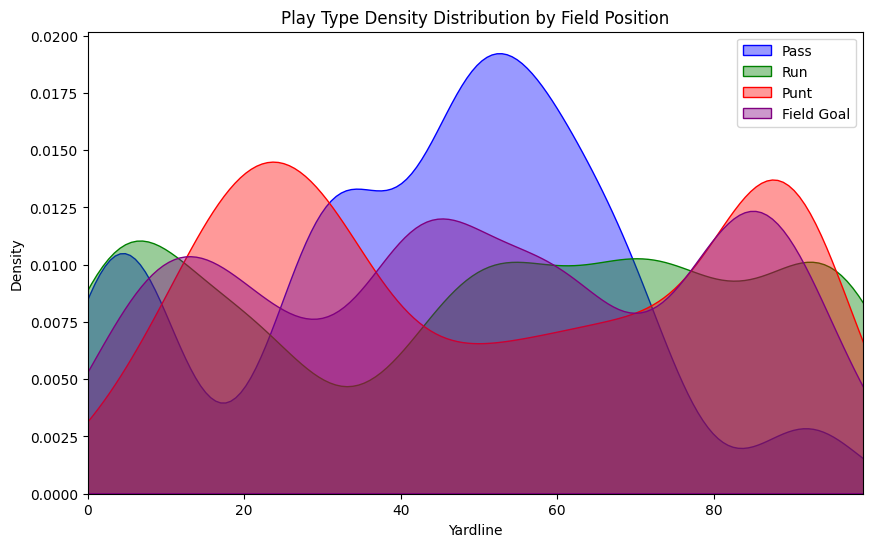

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

test_pandas["yardline_100"] = pd.to_numeric(test_pandas["yardline_100"], errors="coerce")

# Drop any rows with NaN values after conversion
test_pandas = test_pandas.dropna(subset=["yardline_100"])

# Ensure yardline values are within the range 0-99
test_pandas = test_pandas[(test_pandas["yardline_100"] >= 0) & (test_pandas["yardline_100"] <= 99)]

# === KDE Density Plot (Fixed X-Axis Range) === #
plt.figure(figsize=(10, 6))

# Map colors for play types
play_colors = {0: "blue", 1: "green", 2: "red", 3: "purple"}

# KDE plot for each play type
for play_type in [0, 1, 2, 3]:
    sns.kdeplot(
        test_pandas[test_pandas["predicted_play"] == play_type]["yardline_100"],
        label=f"Play Type {play_type}",
        fill=True, color=play_colors[play_type], alpha=0.4,
        bw_adjust=0.5  # Adjust bandwidth for better smoothing
    )

plt.xlabel("Yardline")
plt.ylabel("Density")
plt.title("Play Type Density Distribution by Field Position")
plt.legend(["Pass", "Run", "Punt", "Field Goal"])

plt.xlim(0, 99)

plt.show()